# Reflector imaging from ambient noise signals

In [144]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

Position of the receivers, noise sources, and reflector.

In [230]:
# receivers
x = np.empty((5,3))
x[:, 1:] = [0, 100]
for j in range(5):
    x[j, 0] = -30 + 7.5*j

# reflector
z_r = np.array([-5, 0, 65])

# noise sources
N = 200
y = np.random.uniform([-50, -10, 185], [50, 10, 200], (N,3))

Visualizing the position of receivers, reflector and noise sources.

Text(0, 0.5, 'x')

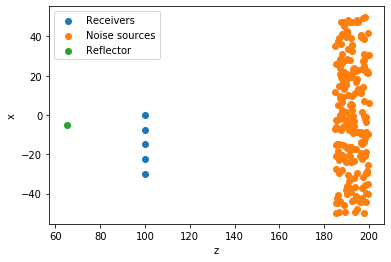

In [231]:
plt.scatter(x[:, 2], x[:, 0], label='Receivers')
plt.scatter(y[:, 2], y[:, 0], label='Noise sources')
plt.scatter(z_r[2], z_r[0], label='Reflector')
plt.legend()
plt.xlabel('z')
plt.ylabel('x')

Parameters of the Green function

In [232]:
# Born approximation parameters for Green's function
c_0 = 1
sigma_r = 1e-3

Green functions: homogeneous solution and Born approximation

In [233]:
# Green functions
G_0_hat = lambda omega, x, y: np.exp(1j * omega / c_0 * np.linalg.norm(x - y)) / (4 * np.pi * np.linalg.norm(x - y))
G_hat = lambda omega, x, y: G_0_hat(omega, x, y) + sigma_r * omega**2 * G_0_hat(omega, x, z_r) * G_0_hat(omega, z_r, y)

Noise sources: stationary zero-mean Gaussain process

In [234]:
F_hat = lambda omega: np.exp(-omega**2)

## Question 1

The integral is estimated with a Riemann sum.

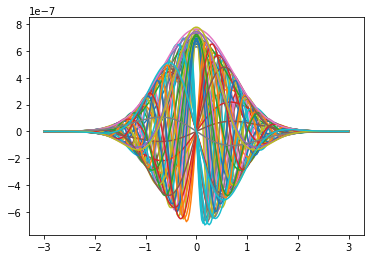

In [235]:
s = 42
for i in range(5):
    for j in range(5):
        omega_ = np.linspace(-3, 3, 200)
        f = [F_hat(omega) * np.conj(G_hat(omega, x[i], y[s])) * G_hat(omega, x[j], y[s]) * np.exp(-1j * omega * 2) for omega in omega_]
        plt.plot(omega_, np.real(f))
        plt.plot(omega_, np.imag(f))

In [236]:
N_omega = 501
omega_array = np.linspace(-3, 3, N_omega)

We use the equation (7) to express the empirical cross correlation in the limit of $T >> 1$. The expression of the Green function is given by the Born approximation.

In [221]:
def C_N(tau, i, j):
    integral = 0
    for s in range(N):
        f = lambda omega: F_hat(omega) * np.conj(G_hat(omega, x[i], y[s])) * G_hat(omega, x[j], y[s]) * np.exp(-1j * omega * tau)
        I = integrate.quad(f, -3, 3)
        integral += I[0]
    return integral / (2 * np.pi * N)

C_N(100, 4, 0)

KeyboardInterrupt: 

In [200]:
def C_N_riemann(tau, i, j, omega_array):
    f_omega = np.zeros(omega_array.shape[0])
    for s in range(N):
        f = lambda omega: F_hat(omega) * np.real(np.conj(G_hat(omega, x[i], y[s])) * G_hat(omega, x[j], y[s]) * np.exp(-1j * omega * tau))
        f_omega += [f(omega) for omega in omega_array]
    integral = integrate.trapz(f_omega)
    return integral / (2 * np.pi * N)

tau = np.linalg.norm(x[4] - z_r) + np.linalg.norm(z_r - x[0])
print(tau)
C_N_riemann(tau, 4, 0, omega_array)

76.15773105863909


2.325735000070783e-12

We introduce a fast version for computing the empirical cross correlation by precomputing all the values of the Green function.

In [237]:
def compute_green_hat(omega_array):
    green_hat = np.zeros((x.shape[0], y.shape[0], omega_array.shape[0]), dtype=complex)
    for i in range(x.shape[0]):
        for s in range(y.shape[0]):
            green_hat[i, s] = np.array([G_hat(omega, x[i], y[s]) for omega in omega_array], dtype=complex)
    return green_hat

omega_array = np.linspace(-3, 3, 500)
green_hat = compute_green_hat(omega_array)
green_hat.shape

(5, 200, 500)

In [238]:
import scipy.integrate as integrate

def C_N_fast(tau, i, j, omega_array, green_hat):
    integral = 0
    F_hat_eitau_omega = np.array([F_hat(omega) * np.exp(-1j * omega * tau) for omega in omega_array], dtype=complex)
    for s in range(N):
        f = np.real(F_hat_eitau_omega * np.conj(green_hat[i, s]) * green_hat[j, s])
        integral += integrate.trapz(f, omega_array)
    result = integral / (2 * np.pi * N)
    return result

C_N_fast(0, 4, 1, omega_array, green_hat)

3.775058342487295e-08

Compute empirical cross correlation when $T >> 1$ for several values of $\tau$.

In [247]:
i = 4
j = 0
tau_array = np.linspace(-200, 200, 1000)
C_N_fast_array = [C_N_fast(tau, i, j, omega_array, green_hat) for tau in tau_array]

Text(0.5, 1.0, '$C_N(\\tau, x_5, x_1)$ en fonction de $\\tau$')

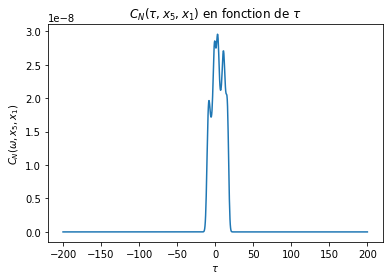

In [248]:
plt.plot(tau_array, C_N_fast_array)
plt.xlabel(r'$\tau$')
plt.ylabel(fr'$C_N(\omega, x_{i+1}, x_{j+1})$')
plt.title(fr'$C_N(\tau, x_{i+1}, x_{j+1})$ en fonction de $\tau$')

(77.87787787787789, 78.36696539454051)

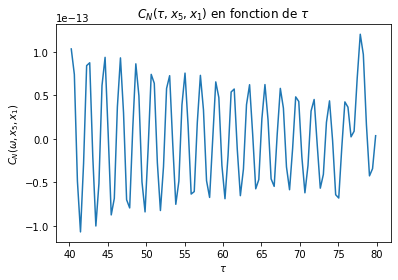

In [249]:
plt.plot(tau_array[600:700], C_N_fast_array[600:700])
plt.xlabel(r'$\tau$')
plt.ylabel(fr'$C_N(\omega, x_{i+1}, x_{j+1})$')
plt.title(fr'$C_N(\tau, x_{i+1}, x_{j+1})$ en fonction de $\tau$')

tau_array[600 + np.argmax(C_N_fast_array[600:700])], np.linalg.norm(x[i] - z_r) + np.linalg.norm(z_r - x[j])

Plotting the KM image.

In [250]:
def I_N(y_S, omega_array, green_hat):
    sum = 0
    for j in range(x.shape[0]):
        for l in range(x.shape[0]):
            tau = np.linalg.norm(x[j] - y_S) + np.linalg.norm(y_S - x[l])
            sum += C_N_fast(tau, j, l, omega_array, green_hat)
    return sum

I_N(z_r, omega_array, green_hat)

5.675289524558971e-13

[-5  0 65]


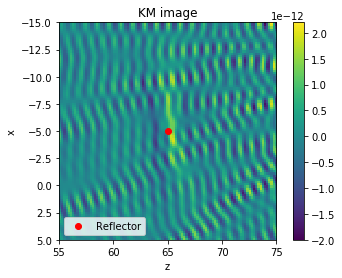

In [254]:
res = 100
win_size = 20
print(z_r)
tx = np.linspace(z_r[0] - win_size / 2, z_r[0] + win_size / 2, res)
tz = np.linspace(z_r[2] - win_size / 2, z_r[2] + win_size / 2, res)
image = np.array([[I_N([x, 0, z], omega_array, green_hat) for z in tz] for x in tx])
np.save('image', image)

plt.figure()
plt.imshow(image, extent=[np.min(tz), np.max(tz), np.max(tx), np.min(tx)])
plt.colorbar()
plt.xlabel('z')
plt.ylabel('x')
plt.scatter(z_r[2], z_r[0], color='r', label='Reflector')
plt.legend(loc=3)
plt.title('KM image')
plt.savefig('KM_image_to_save.png')

Text(0.5, 1.0, 'KM image')

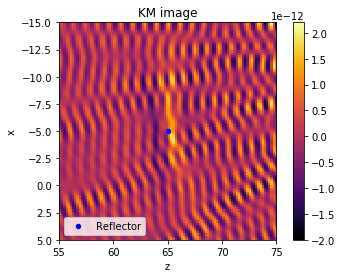

In [276]:
plt.imshow(image, extent=[np.min(tz), np.max(tz), np.max(tx), np.min(tx)], cmap='inferno')
plt.colorbar()
plt.xlabel('z')
plt.ylabel('x')
plt.scatter(z_r[2], z_r[0], color='b', label='Reflector', s=20)
plt.legend(loc=3)
plt.title('KM image')